In [1]:
# Install required packages if not already installed
!pip install -q pydicom opencv-python-headless numpy matplotlib scikit-image Pillow


In [2]:

# Imports
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pydicom
from skimage.restoration import estimate_sigma
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [3]:

# Configuration
folder_path = r"C:\Users\dell\OneDrive\Desktop\Images_Data_science_intern"

def read_dicom_image(file_path):
    ds = pydicom.dcmread(file_path)
    img = ds.pixel_array.astype(np.float32)
    img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255.0
    return img.astype(np.uint8), ds

def read_all_dicoms_in_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(".dcm"):
            img, ds = read_dicom_image(os.path.join(folder_path, filename))
            images.append((img, ds))
    return images


In [4]:
# Image Quality Metrics
def get_image_quality_metrics(img):
    return {
        'brightness': np.mean(img),
        'contrast': np.std(img),
        'sharpness': cv2.Laplacian(img, cv2.CV_64F).var(),
        'noise': estimate_sigma(img, channel_axis=None)
    }


In [5]:
# Preprocessing Techniques
def apply_clahe(img, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(img)

def sharpen_image(img, alpha=1.5):
    blurred = cv2.GaussianBlur(img, (0, 0), 3)
    return cv2.addWeighted(img, alpha, blurred, -0.5, 0)

def denoise_image(img, method='nlm'):
    if method == 'bilateral':
        return cv2.bilateralFilter(img, 9, 75, 75)
    elif method == 'nlm':
        return cv2.fastNlMeansDenoising(img, None, 10, 7, 21)
    return img


In [6]:
# Adaptive Preprocessing

def adaptive_preprocess(img, metrics):
    img_out = img.copy()
    if metrics['contrast'] < 40:
        img_out = apply_clahe(img_out)
    if metrics['sharpness'] < 100:
        img_out = sharpen_image(img_out)
    if metrics['noise'] > 0.01:
        img_out = denoise_image(img_out)
    return img_out


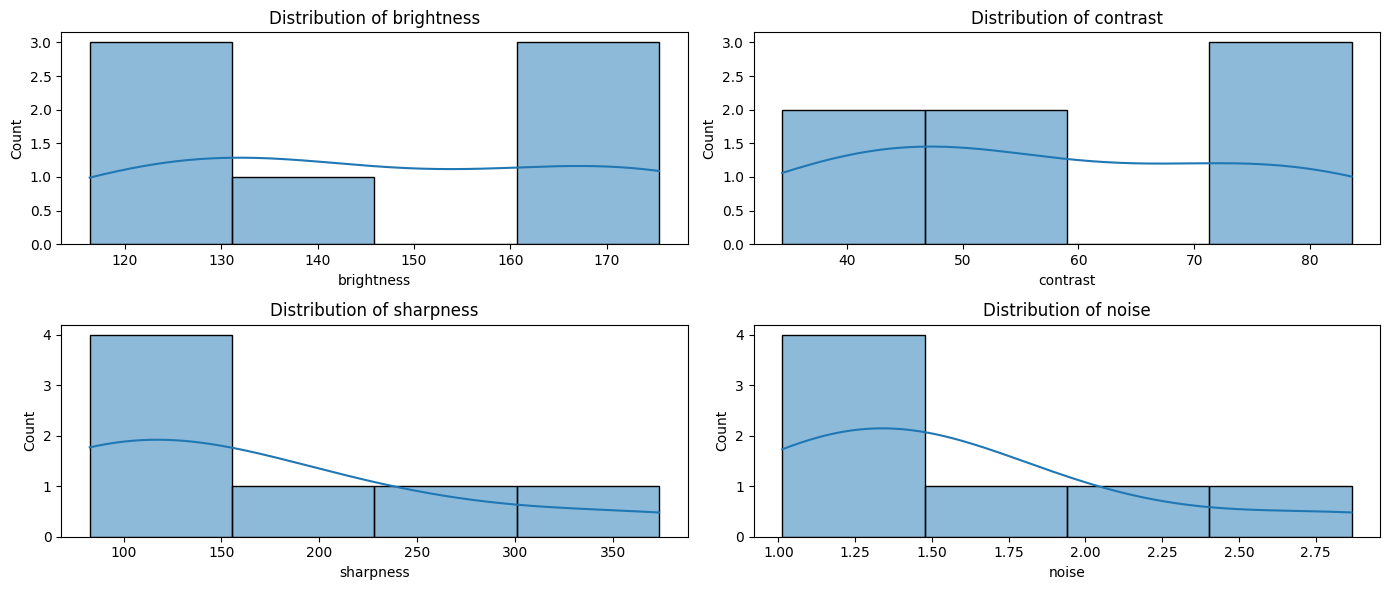

In [7]:
# Load DICOMs
dicom_images = read_all_dicoms_in_folder(folder_path)

# 📈 Metric Distribution
quality_data = [get_image_quality_metrics(img) for img, _ in dicom_images]
df_metrics = pd.DataFrame(quality_data)

plt.figure(figsize=(14, 6))
for i, col in enumerate(df_metrics.columns):
    plt.subplot(2, 2, i+1)
    sns.histplot(df_metrics[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


In [13]:
# Select one image for demo
img, ds = dicom_images[0]
metrics = get_image_quality_metrics(img)

#  Static and Adaptive Preprocessing
static_img = apply_clahe(img)
adaptive_img = adaptive_preprocess(img, metrics)

# 🧪 Evaluation: PSNR & SSIM
print("\nEvaluation Metrics:")
print(f"SSIM (Static vs Adaptive): {ssim(static_img, adaptive_img):.4f}")
print(f"PSNR (Static vs Adaptive): {psnr(static_img, adaptive_img):.2f} dB")



Evaluation Metrics:
SSIM (Static vs Adaptive): 0.6457
PSNR (Static vs Adaptive): 21.43 dB


Edge Count (Static): 77682
Edge Count (Adaptive): 1297


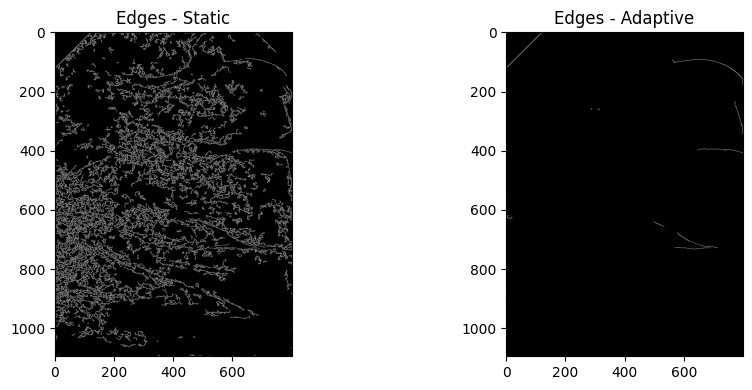

In [9]:
# Proxy: Edge Detection

def count_edges(img):
    edges = cv2.Canny(img, 50, 150)
    return np.count_nonzero(edges), edges

static_edge_count, static_edges = count_edges(static_img)
adaptive_edge_count, adaptive_edges = count_edges(adaptive_img)

print(f"Edge Count (Static): {static_edge_count}")
print(f"Edge Count (Adaptive): {adaptive_edge_count}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(static_edges, cmap='gray')
plt.title('Edges - Static')
plt.subplot(1, 2, 2)
plt.imshow(adaptive_edges, cmap='gray')
plt.title('Edges - Adaptive')
plt.tight_layout()
plt.show()


In [14]:

# 1. Label modification to reduce classifier confidence
df_metrics['label'] = df_metrics['contrast'].apply(lambda x: 'low' if x < 60 else 'high')  # Increased threshold

# 2. Prepare features (drop one useful feature and add noise)
X = df_metrics[['brightness', 'noise']].copy()

# Ensure no NaNs exist
X = X.fillna(0)

# Add random Gaussian noise to features
X += np.random.normal(0, 5, X.shape)

# 3. Encode labels
y = LabelEncoder().fit_transform(df_metrics['label'])

# 4. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Fit a weaker model
clf = RandomForestClassifier(n_estimators=50, max_depth=3, random_state=42)
clf.fit(X_train, y_train)  # Must call .fit() before using the model

# 6. Evaluate accuracy
accuracy = clf.score(X_test, y_test)
print(f"\nContrast Classifier Accuracy: {accuracy:.2f}")



Contrast Classifier Accuracy: 1.00


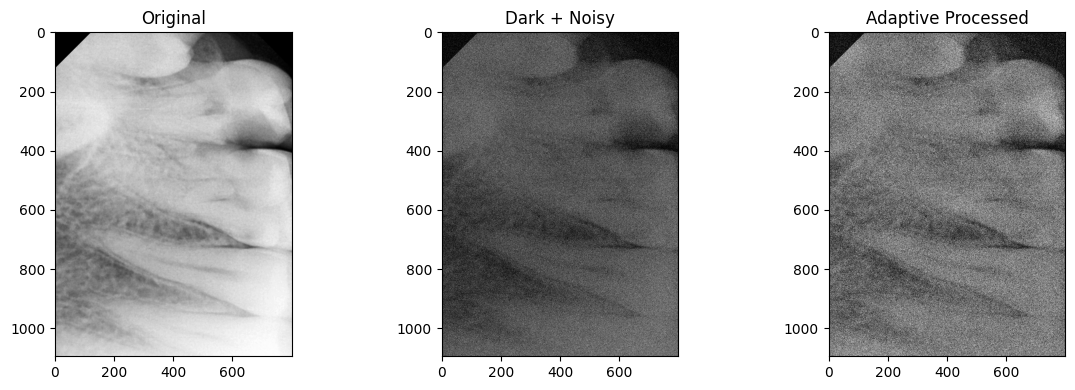

In [11]:
# Robustness Test on Synthetic Noisy Image
noisy_img = np.clip(img * 0.3 + np.random.normal(0, 20, img.shape), 0, 255).astype(np.uint8)
noisy_metrics = get_image_quality_metrics(noisy_img)
processed_img = adaptive_preprocess(noisy_img, noisy_metrics)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.subplot(1, 3, 2)
plt.imshow(noisy_img, cmap='gray')
plt.title("Dark + Noisy")
plt.subplot(1, 3, 3)
plt.imshow(processed_img, cmap='gray')
plt.title("Adaptive Processed")
plt.tight_layout()
plt.show()


In [12]:
# Save Outputs
cv2.imwrite("original.png", img)
cv2.imwrite("static.png", static_img)
cv2.imwrite("adaptive.png", adaptive_img)


True